### Clone & Setup Repo

In [16]:
!git clone https://github.com/axcelerateai/adversarial-robustness-toolbox
%cd adversarial-robustness-toolbox

Cloning into 'adversarial-robustness-toolbox'...
remote: Enumerating objects: 72413, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (119/119), done.
^Cceiving objects:  42% (30483/72413), 219.43 MiB | 7.82 MiB/s 


In [ ]:
!pip install pyfair

### Import Libraies

In [1]:
import csv
import os
import warnings

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from pyfair import FairModel, FairSimpleReport
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

from art.attacks.evasion import LowProFool
from art.estimators.classification.scikitlearn import \
    ScikitlearnLogisticRegression

warnings.filterwarnings(action='ignore')

### Data Utilities

In [7]:

# =====================================================================
# Data utilities
# =====================================================================

def get_custom_dataset(
        filename,
        target_column=None,
        column_names=None,
        random_state=2
    ):
    custom_dataset = pd.read_csv(filename)
    custom_dataset = custom_dataset.sample(frac=1).reset_index(drop=True)
    if column_names:
        custom_dataset = custom_dataset[column_names]

    if target_column:
        X = custom_dataset.drop(target_column, axis=1)
        Y = custom_dataset[target_column]
    else:
        X = custom_dataset.iloc[:, :-1]
        Y = custom_dataset.iloc[:, -1]
    X_scaled =X
    X_scaled, _scaler = standardize(X)

    X_train, y_train, X_valid, y_valid = \
        get_train_and_valid(X_scaled, Y)

    sm = SMOTE(random_state = random_state)

    X_train, y_train = sm.fit_resample(X_train, y_train)
    X_valid, y_valid = sm.fit_resample(X_valid, y_valid)
    return X_train, y_train, X_valid, y_valid

def get_cancer_dataset():
    cancer = datasets.load_breast_cancer()
    design_matrix_cancer = pd.DataFrame(
            data=cancer['data'],
            columns=cancer['feature_names']
    )
    labels_cancer = pd.Series(data=cancer['target'])

    design_matrix_cancer_scaled, cancer_scaler = standardize(
            design_matrix_cancer
    )

    data = get_train_and_valid(design_matrix_cancer_scaled,
                               labels_cancer)

    return data

def standardize(data):
    """
    Get both the standardized data and the used scaler.
    """
    columns = data.columns
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(data)

    return pd.DataFrame(data=x_scaled, columns=columns), scaler

def get_train_and_valid(design_matrix, labels):
    """
    Split dataset into training and validation sets.
    """
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
    for train_idx, valid_idx in split.split(design_matrix, labels):
        X_train = design_matrix.iloc[train_idx].copy()
        X_valid = design_matrix.iloc[valid_idx].copy()
        y_train = labels.iloc[train_idx].copy()
        y_valid = labels.iloc[valid_idx].copy()

    return X_train, y_train, X_valid, y_valid


### Helper Utilities

In [2]:

def write_to_csv(csv_file, config, success_rate, output_dir='visualization'):
    os.makedirs(output_dir, exist_ok=True)
    csv_file = os.path.join(output_dir, csv_file)
    config_dict = config
    if not isinstance(config_dict, dict):
        config_dict = vars(config_dict)
    
    headers = sorted(config_dict.keys())
    if os.path.isfile(csv_file):
        with open(csv_file, 'r') as f:
            reader = csv.reader(f)
            write_headers = (sum([1 for _ in reader]) == 0)
    else:
        write_headers = True

    with open(csv_file, 'a') as f:
        writer = csv.writer(f)
        if write_headers:
            writer.writerow(headers+['success_rate'])
        writer.writerow([config_dict[header] for header in headers]
                        + [success_rate])


### Reports & Plots

In [3]:

def generate_pyfair_report(
        eta_range,
        lambd_range,
        eta_decay_range,
        dataset,
        num_models,
        n_steps_range,
        n_train_samples,
        n_val_samples,
        column_names,
        target_column,
        success_on_class,
        display
    ):
    model_data = {}

    sample_fn = lambda r: np.round(np.random.uniform(r[0], r[1], 1)[0], 3)
    for _ in range(num_models):
        eta = sample_fn(eta_range)
        lambd = sample_fn(lambd_range)
        eta_decay = sample_fn(eta_decay_range)

        success_scores, n_steps_list = plot_line_chart(dataset,
                                                       n_steps_range,
                                                       eta,
                                                       lambd,
                                                       eta_decay,
                                                       n_train_samples,
                                                       n_val_samples,
                                                       column_names,
                                                       target_column,
                                                       success_on_class,
                                                       display,
                                                       plot=False)
        model_name = f'eta: {eta} lambd: {lambd}, eta_decay: {eta_decay}'
        model_data[model_name] = (success_scores, n_steps_list)

    _generate_pyfair_report(model_data)

def _generate_pyfair_report(
        models_data,
        n_simulations=10_000,
        output_dir='visualization',
    ):
    os.makedirs(output_dir, exist_ok=True)

    models = []
    for name, data in models_data.items():
        model = FairModel(f'{name}', n_simulations=n_simulations)
        model.input_data('Threat Event Frequency',
                         mean=np.mean(data[1]),
                         stdev=np.std(data[1]))
        model.input_data('Vulnerability',
                         mean=np.mean(data[0]),
                         stdev=np.std(data[0]))
        model.input_data('Loss Magnitude', constant=1)
        model.calculate_all()
        models.append(model)

    fsr = FairSimpleReport(models, currency_prefix='')
    fsr.to_html(os.path.join(output_dir, 'pyfair_report.html'))

def plot_line_chart(
        dataset,
        n_steps_range,
        eta,
        lambd,
        eta_decay,
        n_train_samples,
        n_val_samples,
        column_names,
        target_column,
        success_on_class,
        display,
        plot=True
    ):

    success_rates = []
    if plot:
        n_steps_list = range(n_steps_range[0], n_steps_range[1]+1)
    else:
        n_steps_list = np.random.randint(n_steps_range[0],
                                         n_steps_range[1]+1,
                                         100,
                                         np.uint8)
        n_steps_list = n_steps_list.tolist()

    for n_step in tqdm(n_steps_list):
        success_rate = create_model_and_attack(
            n_steps=n_step,
            eta=eta,
            lambd=lambd,
            eta_decay=eta_decay,
            n_train_samples=n_train_samples,
            n_val_samples=n_val_samples,
            dataset=dataset,
            column_names=column_names,
            target_column=target_column,
            success_on_class=success_on_class
        )
        success_rates.append(success_rate)

    if plot:
        plot_graph(n_train_samples,
                   n_val_samples,
                   eta,
                   lambd,
                   eta_decay,
                   success_rates,
                   n_steps_range,
                   display=display)

    return success_rates, n_steps_list

def plot_graph(
        n_train_samples,
        n_val_samples,
        eta,
        lambd,
        eta_decay,
        data,
        n_steps_range,
        x_label='n_steps',
        y_label='success_rate (param p in Bernoulli)',
        output_dir='visualization',
        display=True
    ):

    os.makedirs(output_dir, exist_ok=True)
    fig_title = (f'nts: {n_train_samples}, '
                 + f'nvs: {n_val_samples}, '
                 + f'eta: {eta}, '
                 + f'lambd: {lambd}, '
                 + f'eta_decay: {eta_decay}')
    mean = np.mean(data)
    std = np.std(data)

    # Plot
    plt.title(fig_title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.ylim((0, 1.1))
    plt.text(1, 1, f'\u03BC={mean:.2f}, \u03C3={std:.2f}')
    plt.plot(np.arange(n_steps_range[0], n_steps_range[1]+1), data)
    plt.axhline(mean, color='r', linestyle='dashed')
    plt.savefig(f'{output_dir}/{fig_title}.png')
    if display:
        plt.show()

def plot_histogram(
        dataset,
        n_steps_range,
        eta_range,
        lambd_range,
        eta_decay_range,
        n_hist_samples,
        n_train_samples,
        n_val_samples,
        column_names,
        target_column,
        success_on_class,
        display
    ):
    # Sample
    success_rates = []
    sample_fn = lambda r: np.random.uniform(r[0], r[1], 1)[0]
    for i in tqdm(range(n_hist_samples)):
        eta = sample_fn(eta_range)
        lambd = sample_fn(lambd_range)
        eta_decay = sample_fn(eta_decay_range)
        n_steps = sample_fn(n_steps_range)

        success_rate = create_model_and_attack(
            n_steps=int(n_steps),
            eta=eta,
            lambd=lambd,
            eta_decay=eta_decay,
            n_train_samples=n_train_samples,
            n_val_samples=n_val_samples,
            dataset=dataset,
            column_names=column_names,
            target_column=target_column,
            success_on_class=success_on_class
        )
        success_rates.append(success_rate)

    # Plot
    _plot_histogram(
            success_rates,
            fig_title=f'fig-class-{success_on_class}',
            display=display
    )

def _plot_histogram(
        data,
        x_label='success_rate (param p in Bernoulli)',
        y_label='Percentage samples',
        output_dir='visualization',
        fig_title='histogram',
        display=True
    ):
    os.makedirs(output_dir, exist_ok=True)

    plt.title(fig_title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    weights = np.ones(len(data)) / len(data)

    bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    plt.hist(data, bins=bins, weights=weights, edgecolor='black')
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.savefig(os.path.join(output_dir, f'{fig_title}.png'))

    if display:
        plt.show()


### LowRoFool Attack

In [4]:

def lowprofool_generate_adversaries_test_lr(
        lowprofool,
        classifier,
        x_valid,
        y_valid
    ):
    """
    Testing utility.
    """
    n_classes = lowprofool.n_classes

    # Generate targets
    idxs = lambda x: np.random.choice([i for i in range(n_classes) if i != x])
    target = np.eye(n_classes)[np.array(y_valid.apply(idxs))]

    # Generate adversaries
    adversaries = lowprofool.generate(x=x_valid, y=target)

    # Test - check the success rate
    expected = np.argmax(target, axis=1)
    predicted = np.argmax(classifier.predict_proba(adversaries), axis=1)
    correct = (expected == predicted)

    success_rate = np.sum(correct) / correct.shape[0]

    return adversaries, success_rate


### Create Model and run Attack

In [5]:

def create_model_and_attack(
        n_steps=100,
        eta=0.2,
        lambd=0.2,
        eta_decay=0.9,
        n_train_samples=None,
        n_val_samples=None,
        dataset=None,
        column_names=None,
        target_column=None,
        success_on_class=None,
    ):
    if dataset:
        X_train, y_train, X_valid, y_valid = get_custom_dataset(
                dataset,
                target_column=target_column,
                column_names=column_names
        )
    else:
        X_train, y_train, X_valid, y_valid = get_cancer_dataset()

    scaled_clip_values_cancer = (-1., 1.)

    # Take only some samples
    if n_train_samples is not None:
        X_train = X_train[:n_train_samples]
        y_train = y_train[:n_train_samples]
    if n_val_samples is not None:
        X_valid = X_valid[:n_val_samples]
        y_valid = y_valid[:n_val_samples]

    log_regression_clf_cancer = LogisticRegression()
    log_regression_clf_cancer.fit(X_train.values, y_train)

    if success_on_class:
        X_valid = X_valid[y_valid == success_on_class].reset_index(drop=True)
        y_valid = y_valid[y_valid == success_on_class].reset_index(drop=True)

    # Wrapping classifier into appropriate ART-friendly wrapper
    logistic_regression_cancer_wrapper = ScikitlearnLogisticRegression(
        model       = log_regression_clf_cancer,
        clip_values = scaled_clip_values_cancer
    )

    # Creating LowProFool instance
    """
    eta:
    Determines the magnitude of the changes made to the original input to
    create the adversarial example, a larger eta value will result in a
    larger perturbation, which can lead to a higher fooling rate, but may
    also make the perturbation more noticeable and increase the likelihood
    of detection and vice versa.

    eta_decay:
    Used to gradually reduce the eta. This can be useful for improving the
    convergence of the algorithm and avoiding overshooting. The eta decay 
    parameter determines how quickly the step size is reduced over time. A
    higher eta decay value will lead to a slower reduction of the step size,
    while a lower value will lead to a faster reduction. Typically, eta decay
    values are set between 0.9 and 1.0, with larger values corresponding to
    slower decay rates.

    lambd:
    Regularization parameter used to control the trade-off between the size of
    the perturbation and the prediction error of the model. It determines the
    importance of minimizing the distance (change) between the original input 
    and the adversarial input, versus maximizing the prediction error of the
    model on the adversarial input. A larger lambda value will prioritize 
    minimizing the distance, which can lead to a smaller perturbation but 
    potentially lower fooling rate. On the other hand, a smaller lambda value
    will prioritize maximizing the prediction error, which can lead to a higher
    fooling rate but potentially larger perturbations.
    """
    lpf_logistic_regression_cancer = LowProFool(
        n_steps    = n_steps,
        classifier = logistic_regression_cancer_wrapper,
        eta        = eta,
        lambd      = lambd,
        eta_decay  = eta_decay
    )

    # Fitting feature importance
    lpf_logistic_regression_cancer.fit_importances(X_train, y_train)

    # Testing
    results_lr_bc, success_rate = lowprofool_generate_adversaries_test_lr(
        lowprofool = lpf_logistic_regression_cancer,
        classifier = log_regression_clf_cancer,
        x_valid    = X_valid,
        y_valid    = y_valid
    )

    return success_rate


### Run a Sample Test

In [8]:
n_train_samples = 100 # @param {type:"integer"}
n_val_samples = 10 # @param {type:"integer"}
n_steps = 100 # @param {type:"integer"}
eta = 0.2 # @param {type:"number"}
lambd = 0.2 # @param {type:"number"}
eta_decay = 0.9 # @param {type:"number"}
success_on_class = 0 # @param {type:"integer"}

dataset = "" # @param {type: "string", placeholder:"Enter path of the dataset, leave this field to use default dataset `cancer_dataset`"}
column_names = "" # @param {type:"string", placeholder:"Enter column names seperated by `,` comma. Leave this field to use default."}
target_column = "" # @param {type: "string", placeholder:"Enter name of target column. Leave this field to use last column."}
save_csv_file = "report.csv"

if column_names:
    column_names = column_names.split(",")

config = {"n_train_samples": n_train_samples,
          "n_val_samples": n_val_samples,
          "eta": eta,
          "lambd": lambd,
          "eta_decay": eta_decay,
          "success_on_class": success_on_class,
          "dataset": dataset,
          "column_names": column_names,
          "target_column": target_column
          
          }

success_rate = create_model_and_attack(
    n_steps=n_steps,
    eta=eta,
    lambd=lambd,
    eta_decay=eta_decay,
    n_train_samples=n_train_samples,
    n_val_samples=n_val_samples,
    dataset=dataset,
    column_names=column_names,
    target_column=target_column,
    success_on_class=success_on_class
)
write_to_csv(save_csv_file, config, success_rate)
print("Success rate: {:.2f}%".format(100*success_rate))

Success rate: 100.00%


### Generate PayFair Report

In [ ]:
n_train_samples = 100 # @param {type:"integer"}
n_val_samples = 10 # @param {type:"integer"}
num_models = 10 # @param {type:"integer"}

min_n_steps = 1 # @param {type:"integer"}
max_n_steps = 10 # @param {type:"integer"}

min_eta = 0.2 # @param {type:"number"}
max_eta = 0.5 # @param {type:"number"}

min_lambd = 0.2 # @param {type:"number"}
max_lambd = 0.5 # @param {type:"number"}

min_eta_decay = 0.5 # @param {type:"number"}
max_eta_decay = 0.9 # @param {type:"number"}

success_on_class = 0 # @param {type:"integer"}

dataset = "" # @param {type: "string", placeholder:"Enter path of the dataset, leave this field to use default dataset `cancer_dataset`"}
column_names = "" # @param {type:"string", placeholder:"Enter column names seperated by `,` comma. Leave this field to use default."}
target_column = "" # @param {type: "string", placeholder:"Enter name of target column. Leave this field to use last column."}

if column_names:
    column_names = column_names.split(",")

eta_range = [min_eta, max_eta]
lambd_range = [min_lambd, max_lambd]
eta_decay_range = [min_eta_decay, max_eta_decay]
n_steps_range = [min_n_steps, max_n_steps]

generate_pyfair_report(
                eta_range,
                lambd_range,
                eta_decay_range,
                dataset,
                num_models,
                n_steps_range,
                n_train_samples,
                n_val_samples,
                column_names,
                target_column,
                success_on_class,
                False
        )

### Plot Line Chart

In [ ]:
n_train_samples = 100 # @param {type:"integer"}
n_val_samples = 10 # @param {type:"integer"}

min_n_steps = 1 # @param {type:"integer"}
max_n_steps = 10 # @param {type:"integer"}

eta = 0.2 # @param {type:"number"}
lambd = 0.2 # @param {type:"number"}
eta_decay = 0.9 # @param {type:"number"}

success_on_class = 0 # @param {type:"integer"}

dataset = "" # @param {type: "string", placeholder:"Enter path of the dataset, leave this field to use default dataset `cancer_dataset`"}
column_names = "" # @param {type:"string", placeholder:"Enter column names seperated by `,` comma. Leave this field to use default."}
target_column = "" # @param {type: "string", placeholder:"Enter name of target column. Leave this field to use last column."}

if column_names:
    column_names = column_names.split(",")

n_steps_range = [min_n_steps, max_n_steps]

plot_line_chart(
                dataset,
                n_steps_range,
                eta,
                lambd,
                eta_decay,
                n_train_samples,
                n_val_samples,
                column_names,
                target_column,
                success_on_class,
                False
        )

### Plot Histograms

100%|██████████| 1000/1000 [00:06<00:00, 151.79it/s]


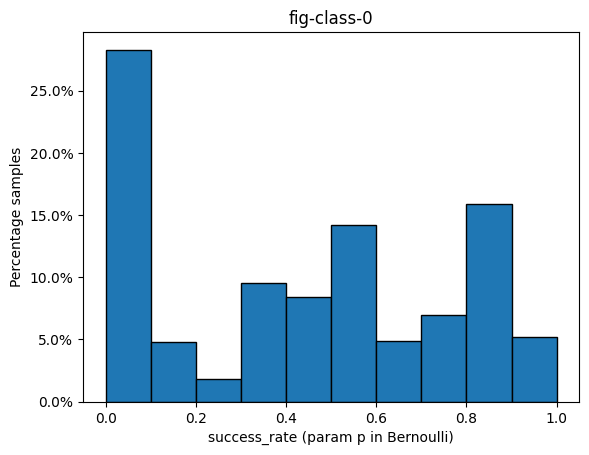

In [15]:
n_train_samples = 100 # @param {type:"integer"}
n_val_samples = 10 # @param {type:"integer"}
n_hist_samples = 1000 # @param {type:"integer"}

min_n_steps = 1 # @param {type:"integer"}
max_n_steps = 10 # @param {type:"integer"}

min_eta = 0.2 # @param {type:"number"}
max_eta = 0.5 # @param {type:"number"}

min_lambd = 0.2 # @param {type:"number"}
max_lambd = 0.5 # @param {type:"number"}

min_eta_decay = 0.5 # @param {type:"number"}
max_eta_decay = 0.9 # @param {type:"number"}

success_on_class = 0 # @param {type:"integer"}

dataset = "" # @param {type: "string", placeholder:"Enter path of the dataset, leave this field to use default dataset `cancer_dataset`"}
column_names = "" # @param {type:"string", placeholder:"Enter column names seperated by `,` comma. Leave this field to use default."}
target_column = "" # @param {type: "string", placeholder:"Enter name of target column. Leave this field to use last column."}

if column_names:
    column_names = column_names.split(",")

eta_range = [min_eta, max_eta]
lambd_range = [min_lambd, max_lambd]
eta_decay_range = [min_eta_decay, max_eta_decay]
n_steps_range = [min_n_steps, max_n_steps]

plot_histogram(
                dataset,
                n_steps_range,
                eta_range,
                lambd_range,
                eta_decay_range,
                n_hist_samples,
                n_train_samples,
                n_val_samples,
                column_names,
                target_column,
                success_on_class,
                False
        )